# Investigating competition effects between WT, SL pre-miRNAs

Model optimised on data from [Tustsumi _et al._, 2011](https://doi.org/10.1038/nsmb.2125)

## Set up workspace

In [1]:
import model_utils as mu
import params
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm

In [2]:
csv_dir = './outputs/wt-sl-comp/csvs/'
fig_dir = './outputs/wt-sl-comp/plots/'

## Set up models

Prepare models for investigating the effects of restricting Dicer availability when

1. Wild-type (WT) pre-miRNA matures alone
2. Short loop (SL) pre-miRNA matures alone
3. When WT and SL pre-miRNAs compete for Dicer

In [3]:
#prep model params
##running models seprarately
inits = [params.init_pMiR1, params.init_pMiR1_dcr, \
         params.init_pMiR1_dcr_star, params.init_MiR1,
         2]#placeholder Dicer

wt_rates = ([params.ka1], [params.Kd_wt * params.ka1],
            [params.kc1], [params.kd1])
short_rates = ([params.ka2], [params.Kd_short * params.ka2], \
               [params.kc2], [params.kd2])

##competing models
comp_inits = [params.init_pMiR1, params.init_pMiR1_dcr, \
         params.init_pMiR1_dcr_star, params.init_MiR1] * 2 + [2]
comp_rates = ([params.ka1, params.ka2], [params.Kd_wt * params.ka1, params.Kd_short * params.ka2],
            [params.kc1, params.kc2], [params.kd1, params.kd2])

In [4]:
#create ODEs
ode_single = mu.makeODEs(inits, [params.ka1], [params.Kd_wt * params.ka1], [params.kc1], [params.kd1])
ode_comp = mu.makeODEs(comp_inits, [params.ka1, params.ka2], [params.Kd_wt * params.ka1, params.Kd_short * params.ka2],
            [params.kc1, params.kc2], [params.kd1, params.kd2])

In [5]:
#set up models
model_single = mu.makeModel(ode_single)
model_comp = mu.makeModel(ode_comp)

In [6]:
#set up Dicer concentrations
dvars = np.linspace(0,5, 11)
dvars[0] = 0.01
variations = [str(int(i * 100)) for i in dvars]

## Run models

In [7]:
#run single models
##create RunModel for single conditions
exec(model_single)

rates = [wt_rates, short_rates]
conds = ['wt', 'short']
names_single = []

for j in tqdm(range(len(dvars))):
    for i in range(len(rates)):
        inits[-1] = dvars[j]
        res = solve_ivp(runModel, (0, int(params.minutes)), inits, \
                           args = rates[i], method = 'LSODA')
    
        mirna_length = int((len(res.y) -1)/4)
        index = []
    
        for k in range(mirna_length):
            index = index + ['pMiR' + str(k), 'pMiR_dicer' + str(k), \
                             'pMiR_dicer_star' + str(k), 'miR' + str(k)]
        
        index = index + ['dicer']
    
        df = pd.DataFrame(res.y, index = index)
            
        df = df.transpose()
        df.insert(loc = 0, column = "time_min", value = res.t)
    
        name = conds[i] + '_' + str(variations[j])
        names_single.append(name)
        
        df.to_csv(csv_dir + name + '.csv', index = False)


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 122.28it/s]


In [8]:
#run competition models
##initialise RunModel for competition conditions
exec(model_comp)

names_comp = []
for i in tqdm(range(len(dvars))):
    comp_inits[-1] = dvars[i]
    
    res = solve_ivp(runModel, (0, int(params.minutes)), comp_inits, \
                       args = comp_rates, method = 'LSODA')
    
    mirna_length = int((len(res.y) -1)/4)
    index = []
    
    for j in range(mirna_length):
        index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                         'pMiR_dicer_star' + str(j), 'miR' + str(j)]
        
    index = index + ['dicer']
    
    df = pd.DataFrame(res.y, index = index)
            
    df = df.transpose()
    df.insert(loc = 0, column = "time_min", value = res.t)
    
    name = 'comp_' + str(variations[i]) 
    names_comp.append(name)
    
    df.to_csv(csv_dir + name + '.csv', index = False)


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 173.36it/s]


## Load data

In [9]:
for name in names_single:
    exec(name + ' = pd.read_csv("' + csv_dir + name + '.csv", header = [0])')
for name in names_comp:
    exec(name + ' = pd.read_csv("' + csv_dir + name + '.csv", header = [0])')

## Plot models

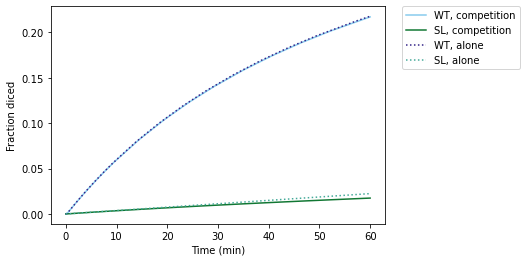

In [10]:
#Plot mature miRNA over time at 1nM

fig, ax = plt.subplots()

#competition, wt 1nM
ax.plot(comp_100['time_min'],
        comp_100['miR0'],
        color = params.colors[0][1],
        linestyle = '-')
#competition, short 1nM
ax.plot(comp_100['time_min'],
        comp_100['miR1'],
        color = params.colors[1][1],
        linestyle = '-')
#wt only, 1nM
ax.plot(wt_100['time_min'],
        wt_100['miR0'],
        color = params.colors[0][0],
        linestyle = ':')
#short only, 1nM
ax.plot(short_100['time_min'],
        short_100['miR0'],
        color = params.colors[1][0],
       linestyle = ':')

ax.set_ylabel('Fraction diced')
ax.set_xlabel('Time (min)')

l1 = mlines.Line2D([], [], linestyle = '-', color = params.colors[0][1], label = 'WT, competition')
l2 = mlines.Line2D([], [], linestyle = '-', color = params.colors[1][1], label = 'SL, competition')
l3 = mlines.Line2D([], [], linestyle = ':', color = params.colors[0][0], label = 'WT, alone')
l4 = mlines.Line2D([], [], linestyle = ':', color = params.colors[1][0], label = 'SL, alone')

plt.legend(handles = [l1, l2, l3, l4], bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

plt.savefig(fig_dir + 'mirna_time_all_1nM.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

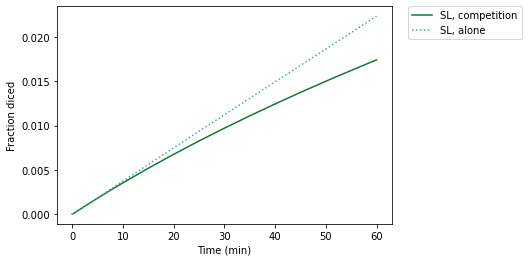

In [11]:
#plot only short loops
fig, ax = plt.subplots()

#competition, short 1nM
ax.plot(comp_100['time_min'],
        comp_100['miR1'],
        color = params.colors[1][1],
        linestyle = '-')
#short only, 1nM
ax.plot(short_100['time_min'],
        short_100['miR0'],
        color = params.colors[1][0],
       linestyle = ':')

ax.set_ylabel('Fraction diced')
ax.set_xlabel('Time (min)')

l2 = mlines.Line2D([], [], linestyle = '-', color = params.colors[1][1], label = 'SL, competition')
l4 = mlines.Line2D([], [], linestyle = ':', color = params.colors[1][0], label = 'SL, alone')

plt.legend(handles = [l2, l4], bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

plt.savefig(fig_dir + 'mirna_time_short_1nM.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

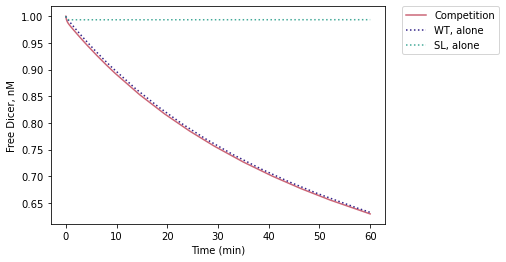

In [12]:
#Plot Dicer availability vs time, 1nM models
fig, ax = plt.subplots()

#competition, 1nM
ax.plot(comp_100['time_min'],
        comp_100['dicer'],
        color = params.colors[3][0],
        linestyle = '-')
#wt only, 1nM
ax.plot(wt_100['time_min'],
        wt_100['dicer'],
        color = params.colors[0][0],
        linestyle = ':')
#short only, 1nM
ax.plot(short_100['time_min'],
        short_100['dicer'],
        color = params.colors[1][0],
       linestyle = ':')

ax.set_ylabel('Free Dicer, nM')
ax.set_xlabel('Time (min)')

l1 = mlines.Line2D([], [], linestyle = '-', color = params.colors[3][0], label = 'Competition')
l2 = mlines.Line2D([], [], linestyle = ':', color = params.colors[0][0], label = 'WT, alone')
l3 = mlines.Line2D([], [], linestyle = ':', color = params.colors[1][0], label = 'SL, alone')

plt.legend(handles = [l1, l2, l3], bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

plt.savefig(fig_dir + 'dicer_time_all_1nM.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [13]:
#plot final mature miRNA vs initial Dicer concentration
##create data for plotting
mirna_end = {'wt': [], 'sl': [], 'comp_wt': [], 'comp_sl': []}
fc_end = {'wt': [], 'sl': [], 'comp_wt': [], 'comp_sl': []}

for i in range(len(dvars)):
    #iteratively load datasets
    exec('wt = wt_' + variations[i])
    exec('short = short_' + variations[i])
    exec('comp = comp_' + variations[i])
    
    mirna_end['wt'].append(wt['miR0'].iloc[-1])
    mirna_end['sl'].append(short['miR0'].iloc[-1])
    mirna_end['comp_wt'].append(comp['miR0'].iloc[-1])
    mirna_end['comp_sl'].append(comp['miR1'].iloc[-1])
    
    fc_end['wt'].append(wt['miR0'].iloc[-1] / wt_500['miR0'].iloc[-1])
    fc_end['sl'].append(short['miR0'].iloc[-1] / short_500['miR0'].iloc[-1])
    fc_end['comp_wt'].append(comp['miR0'].iloc[-1] / comp_500['miR0'].iloc[-1])
    fc_end['comp_sl'].append(comp['miR1'].iloc[-1] / comp_500['miR1'].iloc[-1])

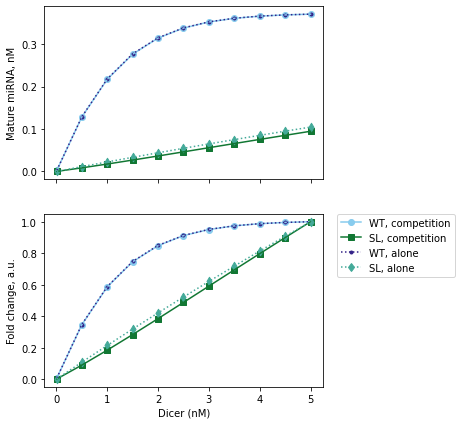

In [14]:
#plot mature miRNA vs initial Dicer concentration
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylabel('Mature miRNA, nM')

ax[0].plot(dvars,
           mirna_end['comp_wt'],
           linestyle = '-',
           color = params.colors[0][1])
ax[0].plot(dvars,
           mirna_end['comp_sl'],
           linestyle = '-',
           color = params.colors[1][1])
ax[0].plot(dvars,
           mirna_end['wt'],
           linestyle = ':',
           color = params.colors[0][0])
ax[0].plot(dvars,
           mirna_end['sl'],
           linestyle = ':',
           color = params.colors[1][0])

ax[0].scatter(dvars,
           mirna_end['comp_wt'],
           marker = 'o',
           color = params.colors[0][1])
ax[0].scatter(dvars,
           mirna_end['comp_sl'],
           marker = 's',
           color = params.colors[1][1])
ax[0].scatter(dvars,
           mirna_end['wt'],
           marker = '.',
           color = params.colors[0][0])
ax[0].scatter(dvars,
           mirna_end['sl'],
           marker = 'd',
           color = params.colors[1][0])

ax[1].set_ylabel('Fold change, a.u.')
ax[1].set_xlabel('Dicer (nM)')

ax[1].plot(dvars,
           fc_end['comp_wt'],
           linestyle = '-',
           color = params.colors[0][1])
ax[1].plot(dvars,
           fc_end['comp_sl'],
           linestyle = '-',
           color = params.colors[1][1])
ax[1].plot(dvars,
           fc_end['wt'],
           linestyle = ':',
           color = params.colors[0][0])
ax[1].plot(dvars,
           fc_end['sl'],
           linestyle = ':',
           color = params.colors[1][0])

ax[1].scatter(dvars,
           fc_end['comp_wt'],
           marker = 'o',
           color = params.colors[0][1])
ax[1].scatter(dvars,
           fc_end['comp_sl'],
           marker = 's',
           color = params.colors[1][1])
ax[1].scatter(dvars,
           fc_end['wt'],
           marker = '.',
           color = params.colors[0][0])
ax[1].scatter(dvars,
           fc_end['sl'],
           marker = 'd',
           color = params.colors[1][0])

l1 = mlines.Line2D([], [], linestyle = '-', marker = 'o', color = params.colors[0][1], label = 'WT, competition')
l2 = mlines.Line2D([], [], linestyle = '-', marker = 's', color = params.colors[1][1], label = 'SL, competition')
l3 = mlines.Line2D([], [], linestyle = ':', marker = '.', color = params.colors[0][0], label = 'WT, alone')
l4 = mlines.Line2D([], [], linestyle = ':', marker = 'd', color = params.colors[1][0], label = 'SL, alone')

plt.legend(handles = [l1, l2, l3, l4], bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)

plt.savefig(fig_dir + 'mirna_fc_vs_dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()